## <u>LUNARLANDER DQN KERAS with Prioritized Replay Buffer</u>

The naive DQN version of CARTPOLE now is improved by adding a PRIORITY BUFFER CONFIGURATION <br>

This example converges around 400 epochs but it is highly unstable. You can try to make it more stable<br>

A classical priority buffer with evaluation based on the TD calculation <br>

Different priority buffer configurations <br>
<br>
High priority (focuses more on important experiences) <br>
    `replay_buffer_high_priority = PriorityReplayBuffer(MEMORY_SIZE, alpha=0.8, beta=0.6)` <br>
<br>
Balanced priority (moderate prioritization) <br>
    `replay_buffer_balanced = PriorityReplayBuffer(MEMORY_SIZE, alpha=0.6, beta=0.4)` <br>
<br>
Low priority (closer to uniform sampling) <br>
    `replay_buffer_low_priority = PriorityReplayBuffer(MEMORY_SIZE, alpha=0.2, beta=0.1)`<br>
    
See paper: https://arxiv.org/abs/1511.05952


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque, namedtuple
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam,AdamW
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

import sys
sys.stderr = open('err.txt', 'w')

I0000 00:00:1751819750.745034 1874251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1751819750.783215 1874251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1751819750.783278 1874251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1751819750.890417 1874251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1751819750.890495 1874251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


#### **Hyperparameters**

In [3]:
MAX_EPISODES = 1000
ROLLING_WINDOW = 20
MEMORY_SIZE = 100000
MAX_STEPS = 500
WARMUP_SIZE = 5000

BETA = 0.6
ALPHA = 0.82
BETA_INCREMENT = 0.0001

gamma = 0.99                         # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995 

learning_rate = 0.0001          # pon 0.0001

batch_size = 128                 # increasing batch size
solved_threshold = 200

verb = 0                             # to see traces (verbosity)

seed_value = 37
np.random.seed(seed_value)

In [4]:
# Environment setup
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


#### **Neural Network**

In [5]:
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")

    x    = Dense(128, activation='relu', name="dense_1")(inputs)
    x    = Dense(64, activation='relu', name="dense_2")(x)
    x    = Dense(32, activation='relu', name="dense_3")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
    model.compile(loss='huber', optimizer=AdamW(learning_rate=learning_rate, clipnorm=1.0))
    return model

DQN = build_model(state_size, action_size)
DQN.summary()

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,620 (45.39 KB)

 Trainable params: 11,620 (45.39 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Priority Replay Buffer Implementation
class PriorityReplayBuffer:
    def __init__(self, capacity, alpha=ALPHA, beta=BETA, beta_increment=BETA_INCREMENT):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent (0 = uniform, 1 = full priority)
        self.beta = beta    # Importance sampling correction (0 = no correction, 1 = full correction)
        self.beta_increment = beta_increment
        self.max_priority = 1.0
        
        # Storage
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
        
        # Experience tuple
        self.Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
    
    def store(self, state, action, reward, next_state, done):
        """Store experience with maximum priority"""
        experience = self.Experience(state, action, reward, next_state, done)
        
        if self.size < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        
        # Assign maximum priority to new experience
        self.priorities[self.position] = self.max_priority
        
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample_experiences(self, batch_size):
        """
        This function samples a group of experiences where more important ones are more likely 
        to be picked. It returns the batch along with correction 
        weights to make sure the agent learns in a stable and unbiased way
        """
#        if self.size < batch_size:
        if self.size < WARMUP_SIZE:
            return None
        
        # Calculate sampling probabilities
        priorities = self.priorities[:self.size]
        probabilities = priorities ** self.alpha
        
        if probabilities.sum() == 0 or np.any(np.isnan(probabilities)):
        # Fall back to uniform distribution if all priorities are zero or invalid
            probabilities = np.ones_like(probabilities) / len(probabilities)
        else:
            probabilities /= probabilities.sum()             # normalize them to 1
        
        # Sample indices based on probabilities
        indices = np.random.choice(self.size, batch_size, p=probabilities, replace=False)
        
        # Get experiences
        experiences = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        # Calculate importance sampling weights
        weights = (self.size * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize weights
        
        # Update beta for next sampling
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards),
            np.vstack(next_states),
            np.array(dones, dtype=np.float32),
            indices,
            weights
        )
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors"""
        for i, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + 1e-6) ** self.alpha  # Small epsilon to avoid zero priority
            self.priorities[i] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return self.size


#### **Support Functions**

In [7]:

def store(state, action, reward, next_state, done):             # memorize
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, model):                                      # act
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    act_values = model.predict_on_batch(state)
    return np.argmax(act_values[0])  # returns action selected with greedy strategy

    
def experience_replay(batch_size, model, epsilon):
    """Experience replay with priority sampling and importance sampling correction"""
    sample_result = replay_buffer.sample_experiences(batch_size)
    
    if sample_result is None:
        return
    
    states, actions, rewards, next_states, dones, indices, weights = sample_result
    
    # Predict Q-values for current and next states
    target_qs = model.predict_on_batch(states)
    next_qs   = model.predict_on_batch(next_states)
    
    # Calculate TD targets
    td_targets = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)
    
    # Calculate TD errors for priority updates
    td_errors = td_targets - target_qs[np.arange(batch_size), actions]
#    td_errors = np.clip(td_errors, -1.0, 1.0)
    
    # Update target Q-values
    target_qs[np.arange(batch_size), actions] = td_targets
    
    # Apply importance sampling weights to the loss
    sample_weights = np.ones(batch_size)  # Default weights
    if hasattr(model, 'sample_weight'):
        sample_weights = weights
    
    # Train the model
    model.train_on_batch(states,target_qs)

#    model.fit(states, target_qs, sample_weight=sample_weights, epochs=1, verbose=0)
    
    # Update priorities in the buffer
    replay_buffer.update_priorities(indices, td_errors)


In [8]:
replay_buffer = PriorityReplayBuffer(MEMORY_SIZE, ALPHA, BETA, BETA_INCREMENT)

rewards_per_episode= []

done = False
rolling_avg = 0
rolling_avg_rewards = []

start_time = time.time()

for e in range(MAX_EPISODES):                           # Should be While True, however we limit number of eps
    state, _ = env.reset(seed = seed_value)
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(MAX_STEPS):
            
        action = select_action_greedy(state, DQN)
        next_state, reward, done, truncated , _ = env.step(action)
                    
        next_state = np.reshape(next_state, [1, state_size])
        replay_buffer.store(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            break
            
        if e > 100 and e < 200:
            batch_size = 128
        elif e > 200 and e < 300:
            batch_size = 256
        elif e > 300:
            batch_size = 1024
            
        if replay_buffer.size > batch_size:               
            experience_replay(batch_size, DQN, epsilon)
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)            # decay epsilon
    
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3} Terminated: {done} "
          f"BS: {batch_size}")

            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
        break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Training completed in {testing_duration:.2f} minutes")

Episode:   1/1000, Reward:  -96.93, Epsilon: 0.99, Rolling Avg: -96.93, Steps:  70 Terminated: True BS: 128
Episode:   2/1000, Reward: -243.20, Epsilon: 0.99, Rolling Avg: -170.07, Steps:  64 Terminated: True BS: 128
Episode:   3/1000, Reward: -115.20, Epsilon: 0.99, Rolling Avg: -151.78, Steps:  58 Terminated: True BS: 128
Episode:   4/1000, Reward:  -70.49, Epsilon: 0.98, Rolling Avg: -131.46, Steps:  70 Terminated: True BS: 128
Episode:   5/1000, Reward: -121.17, Epsilon: 0.98, Rolling Avg: -129.40, Steps:  68 Terminated: True BS: 128
Episode:   6/1000, Reward: -139.09, Epsilon: 0.97, Rolling Avg: -131.01, Steps:  64 Terminated: True BS: 128
Episode:   7/1000, Reward: -225.02, Epsilon: 0.97, Rolling Avg: -144.44, Steps:  61 Terminated: True BS: 128
Episode:   8/1000, Reward: -100.10, Epsilon: 0.96, Rolling Avg: -138.90, Steps:  71 Terminated: True BS: 128
Episode:   9/1000, Reward:  -79.64, Epsilon: 0.96, Rolling Avg: -132.32, Steps:  66 Terminated: True BS: 128
Episode:  10/1000, R

Episode:  77/1000, Reward: -165.12, Epsilon: 0.68, Rolling Avg: -179.67, Steps:  97 Terminated: True BS: 128
Episode:  78/1000, Reward:  -35.13, Epsilon: 0.68, Rolling Avg: -175.49, Steps: 118 Terminated: True BS: 128
Episode:  79/1000, Reward:  -55.69, Epsilon: 0.67, Rolling Avg: -171.82, Steps: 105 Terminated: True BS: 128
Episode:  80/1000, Reward:  -61.51, Epsilon: 0.67, Rolling Avg: -164.71, Steps:  87 Terminated: True BS: 128
Episode:  81/1000, Reward: -126.03, Epsilon: 0.67, Rolling Avg: -162.48, Steps:  94 Terminated: True BS: 128
Episode:  82/1000, Reward: -184.83, Epsilon: 0.66, Rolling Avg: -159.53, Steps: 100 Terminated: True BS: 128
Episode:  83/1000, Reward: -171.16, Epsilon: 0.66, Rolling Avg: -154.68, Steps:  96 Terminated: True BS: 128
Episode:  84/1000, Reward: -100.56, Epsilon: 0.66, Rolling Avg: -147.04, Steps: 101 Terminated: True BS: 128
Episode:  85/1000, Reward: -210.37, Epsilon: 0.65, Rolling Avg: -145.70, Steps:  88 Terminated: True BS: 128
Episode:  86/1000, 

Episode: 153/1000, Reward:  -80.71, Epsilon: 0.46, Rolling Avg: -56.54, Steps: 115 Terminated: True BS: 128
Episode: 154/1000, Reward:  -52.64, Epsilon: 0.46, Rolling Avg: -58.56, Steps: 209 Terminated: True BS: 128
Episode: 155/1000, Reward:  -53.22, Epsilon: 0.46, Rolling Avg: -57.54, Steps: 117 Terminated: True BS: 128
Episode: 156/1000, Reward:  -86.58, Epsilon: 0.46, Rolling Avg: -58.04, Steps:  92 Terminated: True BS: 128
Episode: 157/1000, Reward:  -52.31, Epsilon: 0.46, Rolling Avg: -59.54, Steps: 150 Terminated: True BS: 128
Episode: 158/1000, Reward:  -28.50, Epsilon: 0.45, Rolling Avg: -55.86, Steps: 146 Terminated: True BS: 128
Episode: 159/1000, Reward:   +3.35, Epsilon: 0.45, Rolling Avg: -50.47, Steps: 499 Terminated: False BS: 128
Episode: 160/1000, Reward: -143.53, Epsilon: 0.45, Rolling Avg: -55.17, Steps: 168 Terminated: True BS: 128
Episode: 161/1000, Reward:  -82.45, Epsilon: 0.45, Rolling Avg: -53.69, Steps: 140 Terminated: True BS: 128
Episode: 162/1000, Reward: 

Episode: 229/1000, Reward:   +1.66, Epsilon: 0.32, Rolling Avg: -13.89, Steps: 499 Terminated: False BS: 256
Episode: 230/1000, Reward:   +8.96, Epsilon: 0.32, Rolling Avg:  -7.01, Steps: 499 Terminated: False BS: 256
Episode: 231/1000, Reward:  +16.28, Epsilon: 0.31, Rolling Avg:  -1.31, Steps: 499 Terminated: False BS: 256
Episode: 232/1000, Reward:  +32.32, Epsilon: 0.31, Rolling Avg:  -0.11, Steps: 499 Terminated: False BS: 256
Episode: 233/1000, Reward:  +44.32, Epsilon: 0.31, Rolling Avg:   1.50, Steps: 499 Terminated: False BS: 256
Episode: 234/1000, Reward:  +15.68, Epsilon: 0.31, Rolling Avg:   0.64, Steps: 499 Terminated: False BS: 256
Episode: 235/1000, Reward: -120.65, Epsilon: 0.31, Rolling Avg:  -5.57, Steps: 167 Terminated: True BS: 256
Episode: 236/1000, Reward:  +68.91, Epsilon: 0.31, Rolling Avg:  -0.95, Steps: 499 Terminated: False BS: 256
Episode: 237/1000, Reward:  +47.72, Epsilon: 0.30, Rolling Avg:  10.97, Steps: 499 Terminated: False BS: 256
Episode: 238/1000, R

Episode: 305/1000, Reward: +203.26, Epsilon: 0.22, Rolling Avg:  95.46, Steps: 427 Terminated: True BS: 1024
Episode: 306/1000, Reward: +100.04, Epsilon: 0.22, Rolling Avg:  97.59, Steps: 499 Terminated: False BS: 1024
Episode: 307/1000, Reward: +160.21, Epsilon: 0.21, Rolling Avg:  93.07, Steps: 499 Terminated: False BS: 1024
Episode: 308/1000, Reward: +187.54, Epsilon: 0.21, Rolling Avg:  98.33, Steps: 402 Terminated: True BS: 1024
Episode: 309/1000, Reward:  +56.50, Epsilon: 0.21, Rolling Avg:  97.01, Steps: 499 Terminated: False BS: 1024
Episode: 310/1000, Reward:   -7.99, Epsilon: 0.21, Rolling Avg:  91.43, Steps: 335 Terminated: True BS: 1024
Episode: 311/1000, Reward:  +82.29, Epsilon: 0.21, Rolling Avg:  82.63, Steps: 499 Terminated: False BS: 1024
Episode: 312/1000, Reward:  +33.71, Epsilon: 0.21, Rolling Avg:  77.35, Steps: 499 Terminated: False BS: 1024
Episode: 313/1000, Reward:  +21.82, Epsilon: 0.21, Rolling Avg:  74.30, Steps: 499 Terminated: False BS: 1024
Episode: 314/

Episode: 380/1000, Reward: +101.70, Epsilon: 0.15, Rolling Avg: 106.97, Steps: 499 Terminated: False BS: 1024
Episode: 381/1000, Reward: +116.41, Epsilon: 0.15, Rolling Avg: 107.37, Steps: 499 Terminated: False BS: 1024
Episode: 382/1000, Reward:  +10.18, Epsilon: 0.15, Rolling Avg: 106.74, Steps: 256 Terminated: True BS: 1024
Episode: 383/1000, Reward:  +93.59, Epsilon: 0.15, Rolling Avg: 106.71, Steps: 499 Terminated: False BS: 1024
Episode: 384/1000, Reward: +204.05, Epsilon: 0.15, Rolling Avg: 116.43, Steps: 407 Terminated: True BS: 1024
Episode: 385/1000, Reward:   +1.32, Epsilon: 0.15, Rolling Avg: 117.26, Steps: 246 Terminated: True BS: 1024
Episode: 386/1000, Reward:   -3.68, Epsilon: 0.14, Rolling Avg: 109.62, Steps: 231 Terminated: True BS: 1024
Episode: 387/1000, Reward: +112.96, Epsilon: 0.14, Rolling Avg: 110.22, Steps: 499 Terminated: False BS: 1024
Episode: 388/1000, Reward: +273.15, Epsilon: 0.14, Rolling Avg: 118.12, Steps: 328 Terminated: True BS: 1024
Episode: 389/10

#### **Learning Plot and Episode Rewards**

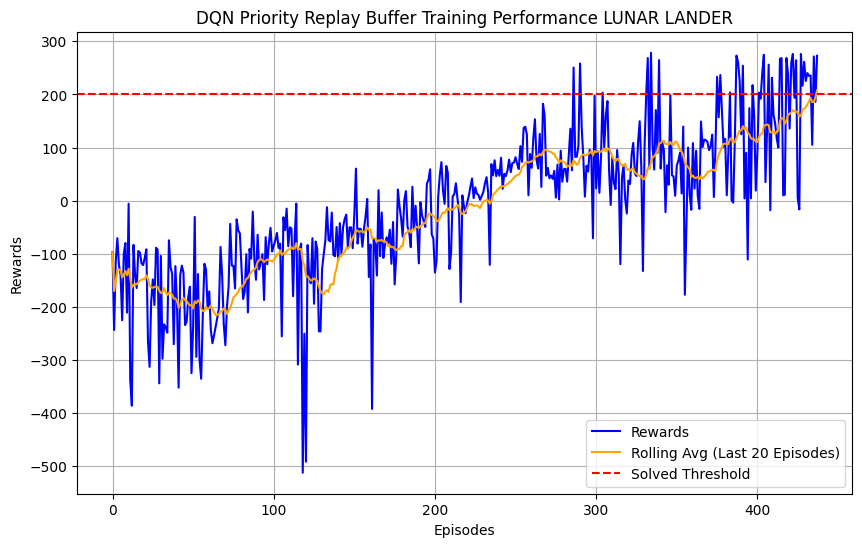

In [9]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Priority Replay Buffer Training Performance LUNAR LANDER')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [10]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
#        action_vals = DQN.predict(state, verbose=0)  # Predict action values
        action_vals = DQN.predict_on_batch(state)
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 25.89, Steps: 908
Test Episode:  2/10, Reward: 257.34, Steps: 324
Test Episode:  3/10, Reward: -31.67, Steps: 384
Test Episode:  4/10, Reward: 208.74, Steps: 407
Test Episode:  5/10, Reward: -45.26, Steps: 344
Test Episode:  6/10, Reward: 220.17, Steps: 268
Test Episode:  7/10, Reward: 253.74, Steps: 320
Test Episode:  8/10, Reward: 241.59, Steps: 479
Test Episode:  9/10, Reward: 247.45, Steps: 385
Test Episode: 10/10, Reward: 10.13, Steps: 1000
Testing completed in 0.17 minutes


#### **Rendering 1 episode**

In [11]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("LunarLander-v3"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = DQN.predict_on_batch(state)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='LUNAR_LANDER_PRB_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='LUNAR_LANDER_PRB_DQN.gif')

Rendered Test Episode Reward: 215.24
Saved GIF to: ./LUNAR_LANDER_PRB_DQN.gif


In [12]:
import session_info
session_info.show(html=False)

-----
PIL                 10.4.0
gymnasium           1.0.0
keras               3.9.0
matplotlib          3.9.1
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.26.0
jupyter_client      8.6.2
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]
Linux-6.6.87.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-07-06 18:58
